In [ ]:
import h3
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import geopandas as gpd
from utils.map_plotting import plot_hex_map
from utils.geospatial_tools import GeoSpatialTools
from utils.process_in_batch import process_parquet_in_chunks

# 1. Data Pre-Processing

In [ ]:
# Ruta del archivo
file_path = "files/mobility_data.parquet"

# Tamaño del chunk
batch_size = 100_000

h8_summary = process_parquet_in_chunks(file_path, batch_size)
h8_summary.to_csv('h8_summary.csv', index=False)


,hex_id,holidays,black_friday,valentine,mothers_day,weekend,friday,night,friday_night,device_id
0,8866d3285dfffff,3233,4785,1042,1228,28872,14390,22258,2970,2399


# 2. Feature Processing & EDA

## 2.1 Check Internal base data

In [2]:
raw_train = pd.read_csv('files/train.csv')
raw_test = pd.read_csv('files/test.csv')
# hex_list = list(set(df_test['hex_id'].unique()).union(set(df_train['hex_id'].unique())))
# len(hex_list)
raw_base = pd.read_csv('files/h8_summary.csv', )
base = raw_base.drop('Unnamed: 0', axis=1)
base = base.groupby('hex_id').agg({'holidays': 'sum', 'black_friday': 'sum', 'valentine': 'sum', 'mothers_day': 'sum',
                             'weekend': 'sum', 'friday': 'sum', 'night': 'sum', 'friday_night': 'sum','device_id': 'sum'}).reset_index()
base['resolution'] = base['hex_id'].apply(h3.get_base_cell_number)
base.head()

,hex_id,holidays,black_friday,valentine,mothers_day,weekend,friday,night,friday_night,device_id,resolution
0,8866d14d05fffff,12317,5904,3530,1831,73082,52039,108118,17973,12457,51
1,8866d14d29fffff,10596,1935,3350,1190,40995,21102,61393,8173,5628,51
2,8866d14d2bfffff,3849,1489,1477,276,19084,11207,21396,3207,4053,51
3,8866d14d63fffff,10080,3251,3597,887,40000,21803,42462,6491,4760,51
4,8866d14d67fffff,2583,1146,718,1049,12342,8230,14296,2148,1835,51


In [3]:
base['in_train']=np.where(base['hex_id'].isin(raw_train['hex_id']), 1, 0)
base['in_test']=np.where(base['hex_id'].isin(raw_test['hex_id']), 1, 0)
base.groupby('resolution').agg({'in_train': 'sum', 'in_test': 'sum'})

,in_train,in_test
resolution,,
51,193,159
71,193,197


We will need to handle missing values as there are less h3_id from train & test dfs

In [4]:
valid_cols = ['device_id', 'holidays', 'black_friday', 'valentine', 'mothers_day', 'weekend', 'friday', 'night', 'friday_night','hex_id']
df_train = raw_train.merge(base[valid_cols], how='left', on='hex_id')
df_train.head()

,hex_id,cost_of_living,device_id,holidays,black_friday,valentine,mothers_day,weekend,friday,night,friday_night
0,8866d338abfffff,0.372854,34852.0,22816.0,14433.0,6598.0,5229.0,168930.0,90691.0,159950.0,25609.0
1,8866d331b1fffff,0.424494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,888f2e3b4dfffff,0.414815,799.0,3931.0,1256.0,546.0,34.0,14695.0,8764.0,10458.0,1670.0
3,888f2b9ae5fffff,0.687205,13258.0,29595.0,3744.0,12335.0,4343.0,144868.0,85094.0,216739.0,32702.0
4,8866d32363fffff,0.482482,496.0,1342.0,52.0,1293.0,416.0,11104.0,6009.0,10655.0,1586.0


## 2.2 Add External features

### Ecuadorian important points

In [ ]:
# Cargar un archivo GeoJSON
# raw_points = gpd.read_file("files\external\hotosm_ecu_points_of_interest_points_geojson.geojson")
# raw_points['hex_id'] = raw_points['geometry'].apply(lambda point: h3.latlng_to_cell(point.y, point.x, 8))
# point_cols = ['amenity', 'shop', 'hex_id', 'geometry']
# df_points = raw_points[point_cols].copy()
# df_points.to_csv('files\external\interes_points.csv', index=False)
# del raw_points




In [6]:
raw_points = pd.read_csv('files\external\interes_points.csv')
amenities = raw_points['amenity'].value_counts().reset_index()
shops = raw_points['shop'].value_counts().reset_index()

# Shops lists orignal
groceries_and_food = ["convenience", "bakery", "supermarket", "greengrocer", "butcher", "alcohol",'beverages']
lux_shop = ['jewelry', 'florist', 'mall', 'gift','confectionery','cinema','theatre']
tech_shop = ["electronics", "mobile_phone", "computer", "stationery", "variety_store"]
cars_shop = ["car_repair", "car_parts", "car", "bicycle", 'tyres']
beauty_shop = ["hairdresser", "beauty", "optician","sports","clothes", "shoes"]
house_shop = ["hardware", "department_store", "furniture", "laundry", "shoes", "kiosk"]
other_shop = ["yes", "travel_agency", "copyshop"]

# Amenities lists original
health_amenities = ["pharmacy", "dentist", "doctors", "clinic", "hospital", "veterinary"]
security_amenities = ["police", 'fire_station']
financial_amenities = ["bank", "atm"]
leisure_amenities = ["restaurant", "fast_food", "cafe", "bar", "ice_cream", "internet_cafe", "community_centre", 'nightclub','pub']
education_amenities = ["school", "college", 'university', 'kindergarten']
car_amenities = ["parking_entrance", "fuel", "parking", 'car_rental', 'car_wash']
transport_amenities = ['bus_station', 'taxi']
public_amenities = ['shelter', 'post_office', 'townhall', 'fountain', 'marketplace', 'bicycle_parking']
negative_amenities = ["waste_disposal", 'love_hotel', 'prison', 'gambling', 'stripclub', 'sanitary_dump_station', 'casino','grave_yard']
sea_amenities = ['boat_rental','scuba_diving', 'ferry_terminal', 'boat_storage', 'dive_centre']
# amenities['amenity'].unique()
# amenities[(amenities['count']<=1) & (amenities['count']>0)]

In [7]:
high_cost_hex = raw_train[raw_train['cost_of_living'] > 0.5]['hex_id'].unique()
low_cost_hex = raw_train[raw_train['cost_of_living'] <= 0.5]['hex_id'].unique()
raw_points['cost_of_living'] = np.where(raw_points['hex_id'].isin(high_cost_hex), 1,
                                        np.where(raw_points['hex_id'].isin(low_cost_hex), 2, 0))
# raw_points.head()

In [ ]:
# financial_amenities = ["bank"]
health_amenities = ["doctors",'veterinary']
security_amenities = ["police", 'fire']
leisure_amenities = ["restaurant", "internet_cafe"] #["cafe", "bar",'nightclub','pub',"fast_food", "community_centre"] #
education_amenities = ["school", "college"] #['university','kindergarten']
car_amenities = ["parking_entrance", "parking", 'bus_station'] # ['car_rental', 'car_wash', "fuel"]
public_amenities = ['shelter', 'post_office', 'townhall', 'marketplace'] # ['bicycle_parking', 'fountain']
negative_amenities = ["waste_disposal"]

# shops
groceries_and_food = ["bakery", "greengrocer", "butcher", "alcohol",'beverages', "convenience", "hardware", "department_store", "laundry"] #["supermarket"]
lux_shop = ['florist', 'gift','confectionery'] # ['mall', 'jewelry', ]
tech_shop = ["electronics", "mobile_phone","beauty", "optician", "shoes"] #["stationery", "variety_store", "computer"]
cars_shop = ["car_parts", 'tyres'] # ["car", "bicycle", "car_repair"]
# beauty_shop = [] #["clothes", "sports","hairdresser"]
# house_shop = [] #["furniture", "kiosk"]
other_shop = ["yes"] #["travel_agency"]

negative_amenities = ["waste_disposal", 'love_hotel', 'prison', 'gambling', 'stripclub', 'sanitary_dump_station', 'casino', 'grave_yard']
sea_amenities = ['boat_rental','scuba_diving', 'ferry_terminal', 'boat_storage', 'dive_centre']


name_test = security_amenities

gdf_points = raw_points.loc[(raw_points['amenity'].isin(name_test)) & (raw_points['cost_of_living']>0)]
gdf_sum = gdf_points['cost_of_living'].value_counts().reset_index()
gdf_sum['total_events'] = gdf_sum['count'].sum()
gdf_sum['proportion'] = round(gdf_sum['count'] / gdf_sum['total_events'], 2)
gdf_sum.sort_values(by='cost_of_living', ascending=True)

,cost_of_living,count,total_events,proportion
1,1,29,117,0.25
0,2,88,117,0.75


### Extract list of coordinates from important points

In [ ]:
raw_interes_points = gpd.read_file("files\external\hotosm_ecu_points_of_interest_points_geojson.geojson")
raw_interes_points.head()

Negative places

In [ ]:
negative_for_coordinates = ["waste_disposal", 'prison']
raw_interes_points['lat_lon'] = raw_interes_points['geometry'].apply(lambda p: (p.y, p.x))

negative_points = raw_interes_points[raw_interes_points['amenity'].isin(negative_for_coordinates)]['lat_lon'].tolist()
# negative_points[:5]



Supermaxi

In [ ]:
raw_supermaxi = raw_interes_points[raw_interes_points['name'].str.contains('supermaxi|megamaxi', case=False, na=False)]
supermaxi_points = raw_supermaxi['lat_lon'].tolist()
# supermaxi_points

car parts

In [104]:
cars_shop_coordinates = ["car_parts", 'tyres']
car_points = raw_interes_points[raw_interes_points['shop'].isin(cars_shop_coordinates)]['lat_lon'].tolist()

education

In [107]:
education_coordinates = ['university','kindergarten']
education_points = raw_interes_points[raw_interes_points['amenity'].isin(education_coordinates)]['lat_lon'].tolist()

Transport

In [190]:
transport_coordinates= ['bus_station', "parking", 'taxi']
transport_points = raw_interes_points[raw_interes_points['amenity'].isin(transport_coordinates)]['lat_lon'].tolist()

Security

In [164]:
security_coordinates = ['fire_station']
security_points = raw_interes_points[raw_interes_points['amenity'].isin(security_coordinates)]['lat_lon'].tolist()
len(security_points)

202

### Calculate volume of important points per hex_id

In [9]:
# Shops
raw_points['groseries_shop'] = np.where(raw_points['shop'].isin(groceries_and_food), 1, 0)
raw_points['lux_shop'] = np.where(raw_points['shop'].isin(lux_shop), 1, 0)
raw_points['tech_shop'] = np.where(raw_points['shop'].isin(tech_shop), 1, 0)
raw_points['car_shop'] = np.where(raw_points['shop'].isin(cars_shop), 1, 0)
# raw_points['beauty_shop'] = np.where(raw_points['shop'].isin(beauty_shop), 1, 0)
# raw_points['house_shop'] =  np.where(raw_points['shop'].isin(house_shop), 1, 0)
raw_points['others'] = np.where(raw_points['shop'].isin(other_shop), 1, 0)

# Amenities
raw_points['health'] = np.where(raw_points['amenity'].isin(health_amenities), 1, 0)
raw_points['security'] = np.where(raw_points['amenity'].isin(security_amenities), 1, 0)
raw_points['financial'] = np.where(raw_points['amenity'].isin(financial_amenities), 1, 0)
raw_points['leisure'] = np.where(raw_points['amenity'].isin(leisure_amenities), 1, 0)
raw_points['education'] = np.where(raw_points['amenity'].isin(education_amenities), 1, 0)
raw_points['cars'] = np.where(raw_points['amenity'].isin(car_amenities), 1, 0)
# raw_points['transport'] = np.where(raw_points['amenity'].isin(transport_amenities), 1, 0)
# raw_points['public'] = np.where(raw_points['amenity'].isin(public_amenities), 1, 0)
raw_points['negative'] = np.where(raw_points['amenity'].isin(negative_amenities), 1, 0)
raw_points['sea'] = np.where(raw_points['amenity'].isin(sea_amenities), 1, 0)

raw_points.head()

,amenity,shop,hex_id,cost_of_living,groseries_shop,lux_shop,tech_shop,car_shop,others,health,security,financial,leisure,education,cars,negative,sea
0,doctors,NaN,8866d338b9fffff,2,0,0,0,0,0,1,0,0,0,0,0,0,0
1,bank,NaN,888f2b98adfffff,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,community_centre,NaN,8866d3069dfffff,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bank,NaN,888f2b8a45fffff,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,fast_food,NaN,8866d33a55fffff,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
operations = {
    'groseries_shop': 'sum',
    'lux_shop': 'sum',
    'tech_shop': 'sum',
    'car_shop': 'sum',
    'others': 'sum',
    'health': 'sum',
    'security': 'sum',
    'financial': 'sum',
    'leisure': 'sum',
    'education': 'sum',
    'cars': 'sum',
    'negative': 'sum',
    'sea': 'sum'
}

df_points = raw_points.groupby('hex_id').agg(operations).reset_index()
df_train_points = raw_train.merge(df_points, how='left', on='hex_id')

### lon-lat distance to places

In [12]:
raw_capitals = pd.read_csv('files/external/lon-lat-capitales.csv')
raw_ports = pd.read_csv('files/external/lon-lat-puertos.csv')

# Create a list of coordinates
capital_coor_list = []
for _, row in raw_capitals.iterrows():
    coordinates = (row['Latitud'], row['Longitud'])
    capital_coor_list.append(coordinates)


port_coor_list = []
for _, row in raw_ports.iterrows():
    coordinates = (row['Latitud'], row['Longitud'])
    port_coor_list.append(coordinates)

In [ ]:
__geo_tools = GeoSpatialTools()
df_train_points['dis_to_capital'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=capital_coor_list))
df_train_points['dis_to_port'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=port_coor_list))
df_train_points['dis_to_negative'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=negative_points))
df_train_points['dis_to_supermaxi'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=supermaxi_points))
df_train_points['dis_car_shop'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=car_points))
df_train_points['dis_to_education'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=education_points))
df_train_points['dis_security'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=security_points))
df_train_points['dis_transport'] = df_train_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=transport_points))

In [ ]:
costa = ['838f0dfffffffff','838f28fffffffff','838f2afffffffff', '838f2bfffffffff', '838f2cfffffffff','838f2efffffffff']
sierra = ['8366d1fffffffff', '8366d3fffffffff', '838f29fffffffff','838f2dfffffffff', '838f72fffffffff','838f76fffffffff']
oriente = ['8366dafffffffff']

df_train_points['h_3'] = df_train_points['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
df_train_points['costa'] = np.where(df_train_points['h_3'].isin(costa), 1, 0)
df_train_points['sierra'] = np.where(df_train_points['h_3'].isin(sierra), 1, 0)
df_train_points['oriente'] = np.where(df_train_points['h_3'].isin(oriente), 1, 0)
# df_train_points

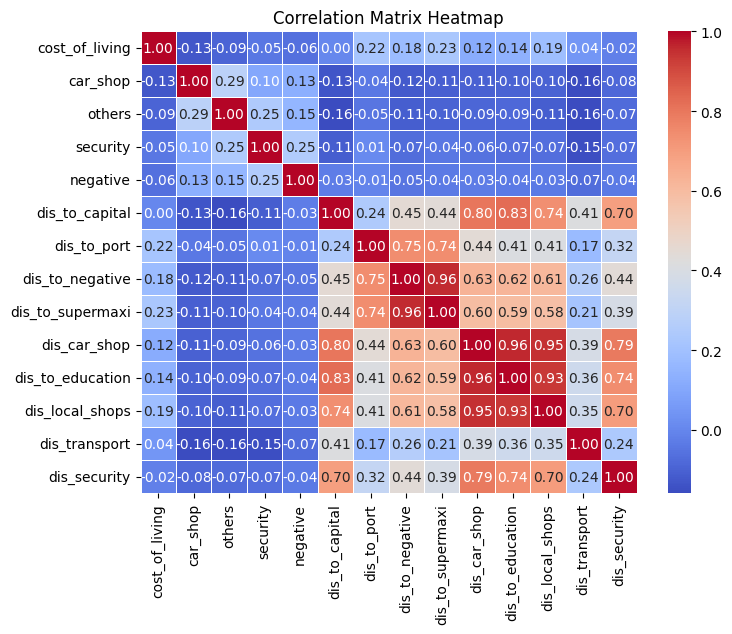

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


valid_num_cols = ['cost_of_living', 'car_shop', 'others', 'security','negative',
       'dis_to_capital', 'dis_to_port','dis_to_negative',
       'dis_to_supermaxi', 'dis_car_shop',
       'dis_to_education', 'dis_local_shops', 'dis_transport', 'dis_security']

    # 'others', 'negative', 'car_shop', 'security', 
    # 'dis_to_capital','dis_to_port', 'dis_to_negative', 'dis_to_supermaxi',
    # 'dis_car_shop', 'dis_to_education',
    # 'costa', 'sierra', 'oriente',

df_filter = df_train_points[valid_num_cols]
# df_filter  = df_filter[(df_filter['cost_of_living']>0) & (df_filter['null_points']==0)]

# ----------------------------------------Heatmap----------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_filter.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()


# -----------------------------------------Pair plot -------------------------------------------
# # variables summary
# cols = df_train_points.columns.tolist()
# sns.set()
# sns.pairplot(df_train_points[cols], size = 2.5)
# plt.show()

# Model Training

## RandomForest Regressor

In [195]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score

df_rf = df_train_points.copy()
df_rf = df_rf.fillna(0)

df_rf['cost_of_living_log'] = df_rf['cost_of_living'].apply(lambda x: np.log(x))

x_cols = [
    'others', 'negative', 'car_shop', 'security', 
    'dis_to_port', 'dis_to_negative', 'dis_transport','dis_to_supermaxi',
    'dis_car_shop', 'dis_to_education',
    'costa', 'sierra', 'oriente',
]

X = df_rf[x_cols]
y = df_rf['cost_of_living_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

# Calcular el Error Cuadrático Medio
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calcular el R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error: 0.07952057620341088
R² Score: 0.5269227293933183
Root Mean Squared Error (RMSE): 0.28199392937333045


### Save model

In [171]:
import pickle

# Guardar el modelo
with open('ml_models/modelo_rf_54.pkl', 'wb') as file:
    pickle.dump(model_rf, file)

# # Cargar el modelo
# with open('modelo.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)
# Verificar que funciona
# y_pred = loaded_model.predict(X_test)

# Model Evaluation

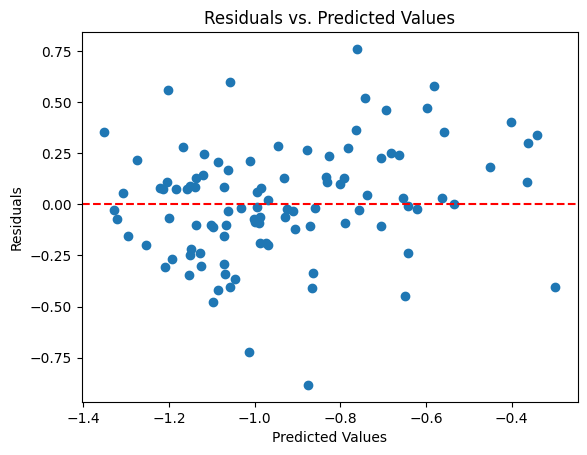

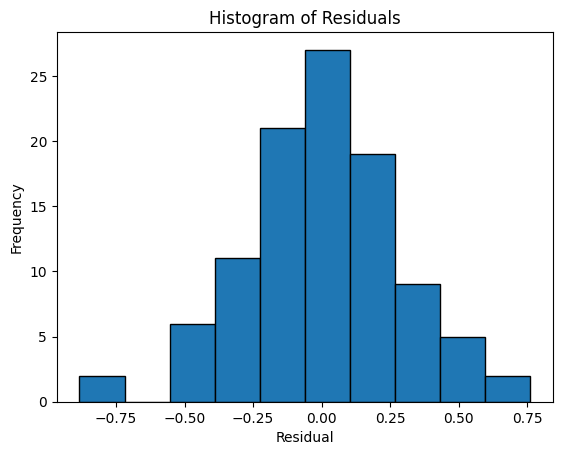

In [189]:
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Model testing

In [214]:
df_test_points = raw_test.merge(df_points, how='left', on='hex_id')

x_cols = [
    'others', 'negative', 'car_shop', 'security', 
    'dis_to_port', 'dis_to_negative', 'dis_transport','dis_to_supermaxi',
    'dis_car_shop', 'dis_to_education',
    'costa', 'sierra', 'oriente',
]


__geo_tools = GeoSpatialTools()
# df_test_points['dis_to_capital'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=capital_coor_list))
df_test_points['dis_to_port'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=port_coor_list))
df_test_points['dis_to_negative'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=negative_points))
df_test_points['dis_to_supermaxi'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=supermaxi_points))
df_test_points['dis_car_shop'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=car_points))
df_test_points['dis_to_education'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=education_points))
# df_test_points['dis_security'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=security_points))


In [215]:
df_test_points['dis_transport'] = df_test_points['hex_id'].apply(lambda x: __geo_tools.hex_distance_from_coordinates(hex=x, coor_list=transport_points))

In [217]:
costa = ['838f0dfffffffff','838f28fffffffff','838f2afffffffff', '838f2bfffffffff', '838f2cfffffffff','838f2efffffffff']
sierra = ['8366d1fffffffff', '8366d3fffffffff', '838f29fffffffff','838f2dfffffffff', '838f72fffffffff','838f76fffffffff']
oriente = ['8366dafffffffff']

df_test_points['h_3'] = df_test_points['hex_id'].apply( lambda x: h3.cell_to_parent(x, res=3))
df_test_points['costa'] = np.where(df_test_points['h_3'].isin(costa), 1, 0)
df_test_points['sierra'] = np.where(df_test_points['h_3'].isin(sierra), 1, 0)
df_test_points['oriente'] = np.where(df_test_points['h_3'].isin(oriente), 1, 0)

In [220]:
df_test_points = df_test_points.fillna(0)
df_test_points.shape

(511, 25)

In [218]:
raw_test.shape

(511, 2)

In [221]:
y_pred_test = model_rf.predict(df_test_points[x_cols])


In [222]:
len(y_pred_test)

511

In [223]:
output = raw_test.copy()
exp_y_pred = np.exp(y_pred_test)
output['cost_of_living'] = exp_y_pred

In [225]:
output.to_csv('model_results/output.csv', index=False)